##Imports

In [135]:
%pip install yfinance
%pip install keras
%pip install tensorflow
%pip install transformers
%pip install torch
%pip install reservoirpy
%pip install seaborn
%pip install matplotlib
%pip install numpy 
%pip install pandas
%pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import reservoirpy as rpy
import torch
import datetime
import seaborn as sns
import tensorflow as tf
import random
import yfinance as yf
import time
import keras
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense, SimpleRNN, Dropout, GRU, Bidirectional, LayerNormalization
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from reservoirpy.nodes import Reservoir, Ridge
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.preprocessing import StandardScaler
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#Data Processing

In [19]:
news = pd.read_excel("C:\\Users\\fatema\\Downloads\\FM\\News.xlsx")
news[["Date", "Author"]] = news["Date"].str.split('|', expand=True)
news = news.drop(columns=["Author"])
news.set_index("Date", inplace=True)
news.index = news.index.str.strip()
news.index = pd.to_datetime(news.index, format='%b %d, %Y at %H:%M', errors='coerce')
news.index = news.index.strftime('%d-%m-%Y')
news.head()

,Headline
Date,
21-06-2024,California Senator Revives $15 Billion Oil Div...
21-06-2024,India's Oil Imports Surge: Russia Hits Record ...
21-06-2024,Gas Flows to Sabine Pass LNG Export Plant Drop...
21-06-2024,Norway To Consider Developing Nuclear Energy
21-06-2024,India Seeks Tighter Regulatory Control Over LN...


In [23]:
model = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', force_download=True)
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
def calculate_sentiment(text):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    scores = torch.nn.functional.softmax(outputs.logits, dim=1)
    sentiment_score = scores[:, 1].item()
    return sentiment_score

# Apply the function to each row in the DataFrame
news['sentiment_score'] = news['Headline'].apply(calculate_sentiment)

# Print the resulting DataFrame with sentimental scores
news=news.drop(columns=["Headline"])
news.head()

,sentiment_score
Date,
21-06-2024,0.000073
21-06-2024,0.999982
21-06-2024,0.000001
21-06-2024,0.000018
21-06-2024,0.999055


In [129]:
news.index = pd.to_datetime(news.index)
news = news.resample('D').mean()
news.index=news.index.strftime("%d-%m-%Y")
news.head()
df = yf.download('CL=F', start='2011-06-15', end='2024-06-21')
df=df[["Open","Adj Close"]]
df.index = pd.to_datetime(df.index)
df.index=df.index.strftime("%d-%m-%Y")
df=df.join(news)
df=df.dropna()
df.head()
df=df.dropna()
df.head()
M=df["Adj Close"].mean()
S=df["Adj Close"].std()
df["Open"]=(df["Open"]-df["Open"].mean())/df["Open"].std()
df["Adj Close"]=(df["Adj Close"]-df["Adj Close"].mean())/df["Adj Close"].std()
df["Open*Score"]=df["Open"]*df["sentiment_score"]
df["lag price"]=df["Adj Close"].shift(1)
df=df.drop(columns=["Open","sentiment_score"])
df=df.dropna()
df.head()

C:\Users\fatema\AppData\Local\Temp\ipykernel_5632\1559215307.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  news.index = pd.to_datetime(news.index)
[*********************100%%**********************]  1 of 1 completed


,Adj Close,Open*Score,lag price
Date,,,
16-06-2011,1.146770,0.000982,1.140380
20-06-2011,1.069634,0.000015,1.146770
21-06-2011,1.076024,0.000017,1.069634
22-06-2011,1.167766,0.000201,1.076024
23-06-2011,0.967394,0.220168,1.167766


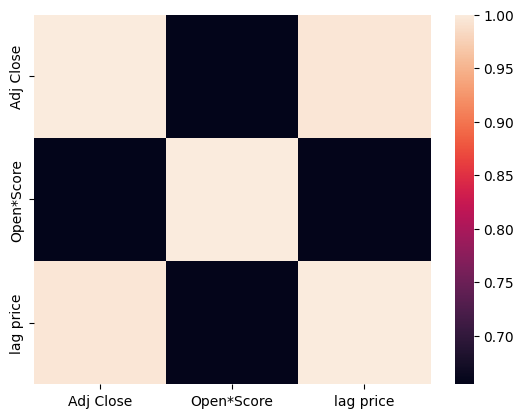

In [25]:
sns.heatmap(df.corr());

#Train and Test Dataset

In [26]:
X=df.drop("Adj Close",axis=1)
Y=df["Adj Close"]
X=X.to_numpy()
X_train,X_test=X[:-48],X[-48:]
Y_train,Y_test=Y[:-48],Y[-48:]
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
Y_train=np.reshape(Y_train, (Y_train.shape[0], 1))
Y_test=np.reshape(Y_test, (Y_test.shape[0],1))
Y_test.shape

(48, 1)

#Simple RNN

In [27]:
RNN=Sequential()
RNN.add(SimpleRNN(units = 20,input_shape = (X_train.shape[1],1)))
RNN.add(Dense(units = 1))
RNN.compile(loss = "mean_squared_error")
T1=time.time()
RNN.fit(X_train, Y_train, epochs = 20, batch_size = 20)
T2=time.time()
RNN.summary()
T_RNN=T2-T1
Y_RNN = RNN.predict(X_test)
Y_RNN

C:\Users\fatema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0933
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0100
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0078
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0080
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0199
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0100
Epoch 10/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064
Epoch 11/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076
Epoch 12/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064
Epoch 13/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071
Epoch 14/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0100
Epoch 15/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 924 (3.61 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 463 (1.81 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step


array([[0.6850705 ],
       [0.71586317],
       [0.6976189 ],
       [0.70218587],
       [0.57654256],
       [0.5800985 ],
       [0.6032932 ],
       [0.58097166],
       [0.6003834 ],
       [0.579993  ],
       [0.612095  ],
       [0.6324842 ],
       [0.57376194],
       [0.5438866 ],
       [0.40745592],
       [0.40641195],
       [0.36644   ],
       [0.38668755],
       [0.37603244],
       [0.405208  ],
       [0.42408442],
       [0.3754908 ],
       [0.4092403 ],
       [0.3668534 ],
       [0.38618863],
       [0.41676968],
       [0.4612795 ],
       [0.44749528],
       [0.42370248],
       [0.3442382 ],
       [0.3096006 ],
       [0.3437344 ],
       [0.44899282],
       [0.4174768 ],
       [0.36061206],
       [0.31938785],
       [0.18958645],
       [0.14515448],
       [0.18336937],
       [0.24624926],
       [0.24539846],
       [0.34911978],
       [0.3615322 ],
       [0.38910693],
       [0.3930701 ],
       [0.38471797],
       [0.47132227],
       [0.518

#Deep RNN

In [28]:
SRNN=Sequential()
SRNN.add(SimpleRNN(units = 20,return_sequences = True,input_shape = (X_train.shape[1],1)))
SRNN.add(Dropout(0.1))
SRNN.add(SimpleRNN(units = 20,return_sequences = True))
SRNN.add(SimpleRNN(units = 20,return_sequences = True))
SRNN.add(SimpleRNN(units = 20))
SRNN.add(Dense(units = 1,activation='linear'))
SRNN.compile(loss = "mean_squared_error")
T1=time.time()
SRNN.fit(X_train, Y_train, epochs = 20, batch_size = 20)
T2=time.time()
T_SRNN=T2-T1
SRNN.summary()
Y_SRNN = SRNN.predict(X_test)
Y_SRNN

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2135
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165
Epoch 10/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160
Epoch 11/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151
Epoch 12/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147
Epoch 13/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155
Epoch 14/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0223
Epoch 15/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 2, 20)          │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 2, 20)          │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 2, 20)          │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,844 (22.83 KB)

 Trainable params: 2,921 (11.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,923 (11.42 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


array([[0.81855637],
       [0.85228896],
       [0.82848877],
       [0.8378215 ],
       [0.70166236],
       [0.70631254],
       [0.733897  ],
       [0.7050845 ],
       [0.7239007 ],
       [0.7044246 ],
       [0.7373895 ],
       [0.7631249 ],
       [0.6986611 ],
       [0.6674737 ],
       [0.5183138 ],
       [0.51753324],
       [0.4733093 ],
       [0.4964427 ],
       [0.4831228 ],
       [0.51535416],
       [0.53805035],
       [0.4838195 ],
       [0.5192154 ],
       [0.4750096 ],
       [0.49388656],
       [0.5281408 ],
       [0.57900846],
       [0.5631828 ],
       [0.5374889 ],
       [0.44953847],
       [0.41077438],
       [0.4472243 ],
       [0.5648654 ],
       [0.52911764],
       [0.46778205],
       [0.42257363],
       [0.27814257],
       [0.22871739],
       [0.27133283],
       [0.3402708 ],
       [0.33934167],
       [0.45419815],
       [0.4692028 ],
       [0.4995834 ],
       [0.50344175],
       [0.49410212],
       [0.58901656],
       [0.636

#Heirarichal RNN

In [29]:
input=Input(shape = (X_train.shape[1],1))
RNN1=SimpleRNN(units = 20,return_sequences = True,input_shape = (X_train.shape[1],1))
RNN_1=RNN1(input)
RNN2=SimpleRNN(units = 20)
RNN_2=RNN2(RNN_1)
Output=Dense(units = 1)
Output=Output(RNN_2)
HRNN=Model(inputs=input,outputs=Output)
HRNN.compile(loss = "mean_squared_error")
T1=time.time()
HRNN.fit(X_train, Y_train, epochs = 20, batch_size =20)
T2=time.time()
HRNN.summary()
T_HRNN=T2-T1
Y_HRNN = HRNN.predict(X_test)
Y_HRNN

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2768
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076
Epoch 10/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093
Epoch 11/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082
Epoch 12/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103
Epoch 13/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095
Epoch 14/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 15/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 2, 20)          │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,564 (10.02 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,283 (5.02 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000020CBB48C0E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


array([[0.69706154],
       [0.72901875],
       [0.70746714],
       [0.7152905 ],
       [0.58686477],
       [0.59146875],
       [0.6182635 ],
       [0.5899149 ],
       [0.6081746 ],
       [0.58930343],
       [0.62062436],
       [0.644808  ],
       [0.5840529 ],
       [0.555427  ],
       [0.41732284],
       [0.41712034],
       [0.3761495 ],
       [0.39874053],
       [0.38403103],
       [0.4139606 ],
       [0.43746078],
       [0.38671157],
       [0.41691986],
       [0.37992474],
       [0.39348796],
       [0.42587566],
       [0.47512728],
       [0.45978218],
       [0.43675736],
       [0.35576537],
       [0.31934538],
       [0.35053095],
       [0.4613767 ],
       [0.42701933],
       [0.3727256 ],
       [0.3323086 ],
       [0.20061961],
       [0.15633808],
       [0.1949062 ],
       [0.25419343],
       [0.25338617],
       [0.35859495],
       [0.37475744],
       [0.40237257],
       [0.405093  ],
       [0.39631838],
       [0.48327032],
       [0.525

#LSTM

In [30]:
lstm=Sequential()
lstm.add(LSTM(units = 20,input_shape = (X_train.shape[1],1)))
lstm.add(Dense(units = 1))
lstm.compile(loss = "mean_squared_error")
T1=time.time()
lstm.fit(X_train, Y_train, epochs = 20, batch_size = 20)
T2=time.time()
lstm.summary()
T_LSTM=T2-T1
Y_LSTM = lstm.predict(X_test)
Y_LSTM

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.8907
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1984
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0209
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0151
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0098
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0079
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0083
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0121
Epoch 10/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062
Epoch 11/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126
Epoch 12/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0063
Epoch 13/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103
Epoch 14/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0078
Epoch 15/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,564 (13.93 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,783 (6.97 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


array([[0.71961474],
       [0.74939895],
       [0.7340695 ],
       [0.73594236],
       [0.61277574],
       [0.6157724 ],
       [0.63763267],
       [0.6181823 ],
       [0.63904667],
       [0.61690235],
       [0.64985514],
       [0.66738117],
       [0.61002   ],
       [0.579619  ],
       [0.44361466],
       [0.44224626],
       [0.40236658],
       [0.4219824 ],
       [0.41278648],
       [0.44183993],
       [0.4592176 ],
       [0.4109605 ],
       [0.44646025],
       [0.4017573 ],
       [0.42340726],
       [0.45331508],
       [0.49639332],
       [0.48298603],
       [0.45891213],
       [0.37937504],
       [0.3449747 ],
       [0.38075757],
       [0.4844591 ],
       [0.45383132],
       [0.39571428],
       [0.3539409 ],
       [0.22301775],
       [0.17785218],
       [0.21657592],
       [0.2814889 ],
       [0.28060955],
       [0.38498572],
       [0.396363  ],
       [0.42410457],
       [0.42841113],
       [0.42013234],
       [0.50696224],
       [0.557

#Deep LSTM

In [31]:
SLSTM=Sequential()
SLSTM.add(LSTM(units = 20,return_sequences = True,input_shape = (X_train.shape[1],1)))
SLSTM.add(Dropout(0.1))
SLSTM.add(LSTM(units = 20,return_sequences = True))
SLSTM.add(LSTM(units = 20,return_sequences = True))
SLSTM.add(LSTM(units = 20))
SLSTM.add(Dense(units = 1))
SLSTM.compile(loss = "mean_squared_error")
T1=time.time()
SLSTM.fit(X_train, Y_train, epochs = 20, batch_size =20)
T2=time.time()
SLSTM.summary()
T_SLSTM=T2-T1
Y_SLSTM = SLSTM.predict(X_test)
Y_SLSTM

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.9299
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1221
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0600
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0155
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173
Epoch 10/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141
Epoch 11/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101
Epoch 12/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0114
Epoch 13/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144
Epoch 14/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106
Epoch 15/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 2, 20)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 2, 20)          │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 2, 20)          │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,244 (90.80 KB)

 Trainable params: 11,621 (45.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,623 (45.41 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


array([[0.7209309 ],
       [0.75245935],
       [0.73675877],
       [0.7380608 ],
       [0.607499  ],
       [0.6105576 ],
       [0.63287586],
       [0.6132218 ],
       [0.6350268 ],
       [0.6118899 ],
       [0.6467433 ],
       [0.6651329 ],
       [0.6045839 ],
       [0.57233655],
       [0.4298392 ],
       [0.4284096 ],
       [0.3869102 ],
       [0.40725195],
       [0.39759988],
       [0.4279337 ],
       [0.4458832 ],
       [0.39583853],
       [0.43261763],
       [0.3861581 ],
       [0.40853465],
       [0.439927  ],
       [0.48461878],
       [0.47081733],
       [0.44560492],
       [0.363046  ],
       [0.3274165 ],
       [0.36412323],
       [0.4723462 ],
       [0.44048584],
       [0.37996283],
       [0.33663526],
       [0.20182517],
       [0.15553245],
       [0.1952213 ],
       [0.26172057],
       [0.26082048],
       [0.3688543 ],
       [0.3805466 ],
       [0.40934825],
       [0.41394037],
       [0.4053561 ],
       [0.49593455],
       [0.548

#Heirarichal LSTM

In [32]:
input=Input(shape = (X_train.shape[1],1))
RNN1=LSTM(units = 20,return_sequences = True,input_shape = (X_train.shape[1],1))
RNN_1=RNN1(input)
RNN2=LSTM(units = 20)
RNN_2=RNN2(RNN_1)
Output=Dense(units = 1)
Output=Output(RNN_2)
HLSTM=Model(inputs=input,outputs=Output)
HLSTM.compile(loss = "mean_squared_error")
T1=time.time()
HLSTM.fit(X_train, Y_train, epochs = 20, batch_size =20)
T2=time.time()
HLSTM.summary()
T_HLSTM=T2-T1
Y_HLSTM = HLSTM.predict(X_test)
Y_HLSTM

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.7932
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0738
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0316
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0107
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0096
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0107
Epoch 10/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059
Epoch 11/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094
Epoch 12/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065
Epoch 13/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055
Epoch 14/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078
Epoch 15/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 2, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 2, 20)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,124 (39.55 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,063 (19.78 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step


array([[0.6827713 ],
       [0.71294963],
       [0.6955644 ],
       [0.6995168 ],
       [0.5762395 ],
       [0.5797301 ],
       [0.60264504],
       [0.58064914],
       [0.59993374],
       [0.5796629 ],
       [0.61135775],
       [0.631119  ],
       [0.5735105 ],
       [0.5442403 ],
       [0.41052294],
       [0.40958172],
       [0.3703708 ],
       [0.39043635],
       [0.37959325],
       [0.40822595],
       [0.42716745],
       [0.37938887],
       [0.4120918 ],
       [0.37117404],
       [0.38947818],
       [0.41957566],
       [0.46359712],
       [0.4499374 ],
       [0.42675406],
       [0.34886378],
       [0.31477684],
       [0.3478526 ],
       [0.45141274],
       [0.42030367],
       [0.36494696],
       [0.3247559 ],
       [0.19762239],
       [0.15421826],
       [0.1916183 ],
       [0.25260222],
       [0.25177583],
       [0.35340077],
       [0.36599332],
       [0.39295512],
       [0.39667442],
       [0.38845688],
       [0.47321713],
       [0.519

#ESN

In [33]:
rpy.verbosity(0)
rpy.set_seed(42)
reservoir = Reservoir(units=150, lr=0.75, sr=1.25,input_dim=2)
readout=Ridge(ridge=1e-5)
ESN = reservoir >> readout
T1=time.time()
ESN = ESN.fit(X_train, Y_train, warmup=50)
T2=time.time()
Y_ESN=ESN.run(X_test)
T_ESN=T2-T1
Y_ESN

array([[0.68644493],
       [0.7092739 ],
       [0.70123628],
       [0.69827442],
       [0.58520765],
       [0.60782153],
       [0.59327367],
       [0.58184003],
       [0.60876052],
       [0.57023333],
       [0.60834056],
       [0.62029083],
       [0.56053771],
       [0.54634531],
       [0.39392252],
       [0.40573947],
       [0.35189177],
       [0.38473098],
       [0.38097523],
       [0.41150852],
       [0.41388146],
       [0.38383431],
       [0.43407269],
       [0.35388272],
       [0.39556885],
       [0.41997563],
       [0.44504515],
       [0.44180015],
       [0.41175537],
       [0.32839551],
       [0.30487798],
       [0.34788398],
       [0.44086001],
       [0.41527371],
       [0.36398209],
       [0.31050575],
       [0.19508893],
       [0.15116712],
       [0.19566425],
       [0.27416453],
       [0.27047205],
       [0.37006807],
       [0.37391482],
       [0.39605239],
       [0.40402288],
       [0.38656004],
       [0.47524951],
       [0.535

#Heirarichal ESN

In [34]:
Node1 = Reservoir(units=150, lr=0.75, sr=1.25,name="N1")
Out1=Ridge(ridge=1e-5,name="O1")
Node2=Reservoir(units=150, lr=0.75, sr=1.25,name="N2")
Out2=Ridge(ridge=1e-5,name="O2")
model = Node1>>Out1>>Node2 >> Out2
T1=time.time()
model = model.fit(X_train, {"O1":Y_train,"O2": Y_train})
T2=time.time()
Y_HESN=model.run(X_test)
T_HESN=T2-T1
Y_HESN

array([[0.69543536],
       [0.72307798],
       [0.71898531],
       [0.69710461],
       [0.58545474],
       [0.60431921],
       [0.59065218],
       [0.58276678],
       [0.61273706],
       [0.57794531],
       [0.6165881 ],
       [0.61272573],
       [0.55427496],
       [0.54822726],
       [0.42430428],
       [0.41154307],
       [0.3555856 ],
       [0.36916872],
       [0.36651784],
       [0.41282147],
       [0.41130053],
       [0.36325136],
       [0.391405  ],
       [0.33287417],
       [0.36189427],
       [0.42170651],
       [0.43935498],
       [0.46162222],
       [0.43479631],
       [0.34995689],
       [0.31140834],
       [0.31458951],
       [0.39605387],
       [0.37831523],
       [0.36098922],
       [0.32288711],
       [0.21651236],
       [0.14133577],
       [0.15817004],
       [0.24400753],
       [0.2509523 ],
       [0.35112284],
       [0.3490764 ],
       [0.38999409],
       [0.40707017],
       [0.37561158],
       [0.45463055],
       [0.487

#Perfomance Comparison

In [188]:
pred=df.iloc[-48:,0].to_frame()
pred = pred.rename(columns={"Adj Close": "Actual"})
pred["Simple RNN"]=Y_RNN
pred["Deep RNN"]=Y_SRNN
pred["Heirarichal RNN"]=Y_HRNN
pred["LSTM"]=Y_LSTM
pred["Deep LSTM"]=Y_SLSTM
pred["Heirarichal LSTM"]=Y_HLSTM
pred["ESN"]=Y_ESN
pred["Heirarichal ESN"]=Y_HESN
pred

,Actual,Simple RNN,Deep RNN,Heirarichal RNN,LSTM,Deep LSTM,Heirarichal LSTM,ESN,Heirarichal ESN
Date,,,,,,,,,
12-04-2024,0.722748,0.685071,0.818556,0.697062,0.719615,0.720931,0.682771,0.686445,0.695435
15-04-2024,0.711337,0.715863,0.852289,0.729019,0.749399,0.752459,0.712950,0.709274,0.723078
16-04-2024,0.709055,0.697619,0.828489,0.707467,0.734070,0.736759,0.695564,0.701236,0.718985
17-04-2024,0.587189,0.702186,0.837821,0.715290,0.735942,0.738061,0.699517,0.698274,0.697105
18-04-2024,0.589015,0.576543,0.701662,0.586865,0.612776,0.607499,0.576240,0.585208,0.585455
19-04-2024,0.607728,0.580099,0.706313,0.591469,0.615772,0.610558,0.579730,0.607822,0.604319
22-04-2024,0.594491,0.603293,0.733897,0.618263,0.637633,0.632876,0.602645,0.593274,0.590652
23-04-2024,0.617769,0.580972,0.705085,0.589915,0.618182,0.613222,0.580649,0.581840,0.582767
24-04-2024,0.592666,0.600383,0.723901,0.608175,0.639047,0.635027,0.599934,0.608761,0.612737


In [192]:
def met(df):

    actual = df.iloc[:, 0]
    values = {
        'Model': [],
        'MSE': [],
        'RMSE': [],
        'R-squared': []
    }
    for c in df.columns[1:]:
        y_a = actual
        y_p = df[c]
        mse = mean_squared_error(y_a, y_p)
        rmse = np.sqrt(mse)
        r_squared = r2_score(y_a, y_p)
        values['Model'].append(c)
        values['MSE'].append(mse)
        values['RMSE'].append(rmse)
        values['R-squared'].append(r_squared)

    values = pd.DataFrame(values)
    values.set_index("Model",inplace=True)
    return values
perf=met(pred).round(4)
T=[T_RNN,T_SRNN,T_HRNN,T_LSTM,T_SLSTM,T_HLSTM,T_ESN,T_HESN]
perf["Time"]=T
perf

,MSE,RMSE,R-squared,Time
Model,,,,
Simple RNN,0.0028,0.0526,0.8445,6.582256
Deep RNN,0.0143,0.1197,0.1941,12.668617
Heirarichal RNN,0.0028,0.0530,0.8422,8.037106
LSTM,0.0035,0.0588,0.8058,6.667738
Deep LSTM,0.0032,0.0562,0.8226,14.978585
Heirarichal LSTM,0.0027,0.0516,0.8500,9.369562
ESN,0.0025,0.0496,0.8618,1.163270
Heirarichal ESN,0.0034,0.0580,0.8107,2.336127


In [194]:
class SmaCross(Strategy):
    n1 = 5
    n2 = 20

    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()
def dat(x):
    df = yf.download("CL=F", start="2024-04-12", end="2024-06-21")
    df.drop(columns=["Adj Close","Close"], inplace=True)
    back=pd.DataFrame(pred[x])
    back.index=df.index
    df["Close"]=back[x]
    df=df[['Open', 'High', 'Low', 'Close', 'Volume']]
    bt = Backtest(df, SmaCross, cash=10_000, commission=.002)
    stats = bt.run()
    equity_final = stats['Equity Final [$]']
    return_percent = stats['Return [%]']
    buy_and_hold_return_percent = stats['Buy & Hold Return [%]']
    sortino_ratio = stats['Sortino Ratio']
    calmar_ratio = stats['Calmar Ratio']
    data = {
    'Equity Final [$]': [equity_final],
    'Return [%]': [return_percent],
    'Buy & Hold Return [%]': [buy_and_hold_return_percent],
    'Sortino Ratio': [sortino_ratio],
    'Calmar Ratio': [calmar_ratio]
    }
    stats_df = pd.DataFrame(data)
    return stats_df
def final(y):
    result = pd.DataFrame()
    for x in y.columns:
        x_values = dat(x)
        result = pd.concat([result, x_values], ignore_index=True)
    result.index = y.columns
    return result
Result = final(pred)
Result["P&L"]=pred.iloc[-1] - pred.iloc[0]
Result



[*********************100%%**********************]  1 of 1 completed


C:\Users\fatema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\backtesting\_stats.py:114: RuntimeWarning: overflow encountered in scalar power
  s.loc['Volatility (Ann.) [%]'] = np.sqrt((day_returns.var(ddof=int(bool(day_returns.shape))) + (1 + gmean_day_return)**2)**annual_trading_days - (1 + gmean_day_return)**(2*annual_trading_days)) * 100  # noqa: E501
[*********************100%%**********************]  1 of 1 completed
C:\Users\fatema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\backtesting\_stats.py:114: RuntimeWarning: overflow encountered in scalar power
  s.loc['Volatility (Ann.) [%]'] = np.sqrt((day_returns.var(ddof=int(bool(day_returns.shape))) + (1 + gmean_day_return)**2)**annual_trading_days - (1 + gmean_day_return)**(2*annual_trading_days)) * 100  # noqa: E501
[*********************100%%**********************]  1 of 1

,Equity Final [$],Return [%],Buy & Hold Return [%],Sortino Ratio,Calmar Ratio,P&L
Actual,10435.721928,4.357219,-22.040020,0.108942,0.252260,-0.159294
Simple RNN,10366.145226,3.661452,-24.311781,0.090296,0.209084,-0.166553
Deep RNN,10366.145226,3.661452,-22.240359,0.090422,0.209376,-0.182050
Heirarichal RNN,10366.145226,3.661452,-24.612261,0.090309,0.209115,-0.171563
LSTM,10366.145226,3.661452,-22.567599,0.090337,0.209178,-0.162400
Deep LSTM,10366.145226,3.661452,-23.929343,0.090320,0.209139,-0.172514
Heirarichal LSTM,10366.145226,3.661452,-23.939463,0.090300,0.209094,-0.163452
ESN,10366.145226,3.661452,-21.994802,0.090298,0.209089,-0.150982
Heirarichal ESN,10366.145226,3.661452,-29.935401,0.090286,0.209059,-0.208181
